# Code for finding best area to set up a gym in Toronto. 
### Import necessary libraries. 

In [6]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
!pip install beatifulsoup4
!pip install lxml

from bs4 import BeautifulSoup

from IPython.display import HTML
from IPython.display import display

print('Libraries imported.')

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

    altair:  4.1.0-py_1 conda-forge
    branca:  0.4.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


vincent-0.4

### Scrape data from website into dataframe

In [7]:
info = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
extract = BeautifulSoup(info,'lxml')
data = str(extract.table)
df = pd.read_html(data)
df1 = df[0]
df1['Borough'].replace('Not assigned',np.nan, inplace =True)
df1.dropna(subset=['Borough'], axis = 0, inplace =True)
df1 = df1.groupby(['Postal Code','Borough'], sort=False).agg(','.join)
df1.reset_index(inplace=True)
df1.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Merge coordinates data with data acquired from website

In [8]:
!wget -q -O 'Geospatial_data.csv' http://cocl.us/Geospatial_data
df2 = pd.read_csv('Geospatial_data.csv')
df3 = pd.merge(df1, df2, on='Postal Code')
df4 = df3[df3['Borough'].str.contains(r'Toro(?!$)')]
df4.reset_index(drop=True, inplace = True)
df4.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Visualize neighborhooods on map

In [9]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df4['Latitude'], df4['Longitude'], df4['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Hidden cell containing Foursquare API data

In [10]:
# Taken from stacksoverflow.com
tag = HTML('''<script>
code_show=true;
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a.''')
display(tag)

# My code #
CLIENT_ID = 'BK4E3AGDZVI5C0ORMM20AOO5GXFN5UPMKQ21YK41P5AFY34P' # your Foursquare ID
CLIENT_SECRET = 'DJGQRKRDQTM5LWUS221TWYJYZZFN5P3CBTYVJDXHSDIQF1FD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Obtain nearby venues with Foursquare API

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
LIMIT = 100
toronto_venues = getNearbyVenues(names=df4['Neighborhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )



Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [13]:
print(toronto_venues.shape)
toronto_venues.head()


(1622, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


### Number of venues per neighbourhood retrieved

In [14]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,65,65,65,65,65,65
Christie,16,16,16,16,16,16
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


In [15]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


### Analyse each neighborhood

In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Determine frequency of venues in each neighborhood

In [17]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2                Café  0.03
3  Seafood Restaurant  0.03
4              Bakery  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.12
1          Bakery  0.08
2     Coffee Shop  0.08
3  Breakfast Spot  0.08
4             Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0       Yoga Studio  0.06
1  Recording Studio  0.06
2        Skate Park  0.06
3    Farmers Market  0.06
4     Burrito Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.18
1       Airport Lounge  0.12
2     Airport Terminal  0.12
3          Coffee Shop  0.06
4  Rental Car Location  0.06


----Central Bay Street----
                 venue  freq
0          Co

### Obtain frequency of gyms in neighborhoods

In [19]:
gym = toronto_grouped[["Neighborhood","Gym"]]
gym.head()

,Neighborhood,Gym
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.041667
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.000000


### Form clusters of neighborhoods

In [20]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = gym.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 0, 2, 2, 3], dtype=int32)

In [21]:
toronto_merged = gym.copy()

toronto_merged["Cluster Labels"] = kmeans.labels_

toronto_merged.head()

,Neighborhood,Gym,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.041667,2
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.000000,0


In [22]:
toronto_merged = toronto_merged.join(toronto_venues.set_index("Neighborhood"), on='Neighborhood')
toronto_merged.head()

,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.0,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.0,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


In [41]:
toronto_merged.shape

(1622, 9)

In [24]:
toronto_merged.sort_values(['Gym'], inplace = True)



### Top 5 neighborhoods with least gyms

In [25]:
toronto_merged.head()

,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
30,"St. James Town, Cabbagetown",0.0,0,43.667967,-79.367675,Salt & Tobacco,43.665307,-79.368335,Pizza Place
12,"Forest Hill North & West, Forest Hill Road Park",0.0,0,43.696948,-79.411307,Kay Gardner Beltline Trail,43.698446,-79.406873,Trail
17,"Kensington Market, Chinatown, Grange Park",0.0,0,43.653206,-79.400049,Meeplemart,43.651628,-79.397410,Gaming Cafe
38,"University of Toronto, Harbord",0.0,0,43.662696,-79.400049,East of Brunswick,43.665609,-79.403324,Pub


### 5 Neighborhoods with most gyms

In [26]:
toronto_merged.tail()

,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Davisville North,0.125,3,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place
9,Davisville North,0.125,3,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
9,Davisville North,0.125,3,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
20,"Moore Park, Summerhill East",0.500,1,43.689574,-79.383160,Ravine,43.690356,-79.386841,Trail
20,"Moore Park, Summerhill East",0.500,1,43.689574,-79.383160,Totum Life Science St. Clair,43.686525,-79.383449,Gym


### Number of neighborhoods in each cluster - Visualized

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<function matplotlib.pyplot.show(*args, **kw)>

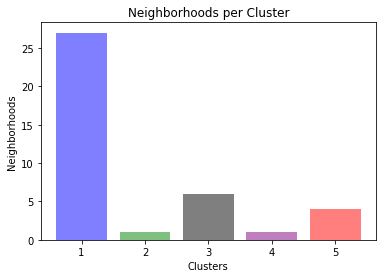

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
gym['Cluster Labels'] = kmeans.labels_
keys = (1,2,3,4,5)
y = np.arange(len(keys))
perf = gym['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
p = perf['Cluster Labels'].tolist()
plt.bar(y,p, alpha=0.5,color=['blue','green','black','purple','red'])
plt.xticks(y,keys)
plt.ylabel('Neighborhoods')
plt.xlabel('Clusters')
plt.title('Neighborhoods per Cluster')
plt.show

### Neighborhood Clusters visualized on map of Toronto

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysing Clusters

In [36]:
df5 = df4[['Borough','Neighborhood']]

Number of gyms per cluster

In [62]:
gym['Cluster Labels'].value_counts()

0    27
2     6
4     4
3     1
1     1
Name: Cluster Labels, dtype: int64

### Cluster 1 - Blue

In [55]:
clus1 = gym.loc[gym['Cluster Labels'] == 0]
dfclus1 = pd.merge(df5,clus1, on='Neighborhood')
dfclus1

,Borough,Neighborhood,Gym,Cluster Labels
0,Downtown Toronto,"Regent Park, Harbourfront",0.00,0
1,Downtown Toronto,"Garden District, Ryerson",0.01,0
2,East Toronto,The Beaches,0.00,0
3,Downtown Toronto,Berczy Park,0.00,0
4,Downtown Toronto,Central Bay Street,0.00,0
5,Downtown Toronto,Christie,0.00,0
6,West Toronto,"Dufferin, Dovercourt Village",0.00,0
7,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",0.00,0
8,West Toronto,"Little Portugal, Trinity",0.00,0
9,East Toronto,"The Danforth West, Riverdale",0.00,0


### Cluster 2 - Green

In [56]:
clus2 = gym.loc[gym['Cluster Labels'] == 1]
dfclus2 = pd.merge(df5,clus2, on='Neighborhood')
dfclus2

,Borough,Neighborhood,Gym,Cluster Labels
0,Central Toronto,"Moore Park, Summerhill East",0.5,1


### Cluster 3 - Black

In [57]:
clus3 = gym.loc[gym['Cluster Labels'] == 2]
dfclus3 = pd.merge(df5,clus3, on='Neighborhood')
dfclus3

,Borough,Neighborhood,Gym,Cluster Labels
0,Downtown Toronto,"Richmond, Adelaide, King",0.042553,2
1,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.041667,2
2,East Toronto,"India Bazaar, The Beaches West",0.041667,2
3,Downtown Toronto,"Commerce Court, Victoria Hotel",0.040000,2
4,Central Toronto,Davisville,0.057143,2
5,Downtown Toronto,"First Canadian Place, Underground city",0.040000,2


### Cluster 4 - Purple

In [58]:
clus4 = gym.loc[gym['Cluster Labels'] == 3]
dfclus4 = pd.merge(df5,clus4, on='Neighborhood')
dfclus4

,Borough,Neighborhood,Gym,Cluster Labels
0,Central Toronto,Davisville North,0.125,3


### Cluster 5 - Red

In [59]:
clus5 = gym.loc[gym['Cluster Labels'] == 4]
dfclus5 = pd.merge(df5,clus5, on='Neighborhood')
dfclus5

,Borough,Neighborhood,Gym,Cluster Labels
0,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,4
1,Downtown Toronto,St. James Town,0.025000,4
2,West Toronto,"Runnymede, Swansea",0.027027,4
3,Downtown Toronto,Stn A PO Boxes,0.020619,4


### Frequency of Gyms in Clusters - Visualized

<function matplotlib.pyplot.show(*args, **kw)>

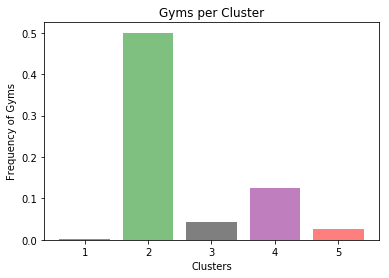

In [60]:
c_mean = [dfclus1['Gym'].mean(),dfclus2['Gym'].mean(),dfclus3['Gym'].mean(),dfclus4['Gym'].mean(),dfclus5['Gym'].mean(),]
key = (1,2,3,4,5)
y1 = np.arange(len(key))
p1 = c_mean
plt.bar(y1,p1, alpha=0.5,color=['blue','green','black','purple','red'])
plt.xticks(y1,key)
plt.ylabel('Frequency of Gyms')
plt.xlabel('Clusters')
plt.title('Gyms per Cluster')

plt.show

## Observation

From the analysis of the bar graphs, it can be noted that the cluster with the most neighborhoods has the least number of gyms. That is Cluster 0. Our analysis has also provided us with the 5 neighborhood which have the least number of gyms and belong to cluster 0. The ideal location for setting up the gym as discussed earlier would be in the neighborhood with the least number of gyms in order to reduce competition. Since cluster 0 is dominated by Downtown Toronto Boroughs, a neighborhood in the bottom 5 with gym frequency such as University of Toronto, Harbord in that borough is suitable.
It has the added bonus of proximity to a university which provides a ready market.